In [3]:
import os
import collections
import matplotlib.pyplot as plt
import torch
import torch.utils.data as Data
import torch.nn as nn
from gensim.models import KeyedVectors
import numpy as np

from textcnn_model_torch import TextCNN

### 数据处理

In [4]:
def read_imdb(data_dir, is_train):
    """读取IMDb评论数据集文本序列和标签"""
    data, labels = [], []
    for label in ('pos', 'neg'):
        folder_name = os.path.join(data_dir, 'train' if is_train else 'test', label)
        for file in os.listdir(folder_name):
            with open(os.path.join(folder_name, file), 'rb') as f:
                review = f.read().decode('utf-8').replace('\n', '')
                data.append(review)
                labels.append(1 if label == 'pos' else 0)
    return data, labels


data_dir = '../../../../../../Other/datasets/aclImdb'
train_data = read_imdb(data_dir, is_train=True)
print('训练集数⽬：', len(train_data[0]))
for x, y in zip(train_data[0][:3], train_data[1][:3]):
    print('标签：', y, 'review:', x[0:60])

训练集数⽬： 25000
标签： 1 review: Bromwell High is a cartoon comedy. It ran at the same time a
标签： 1 review: Homelessness (or Houselessness as George Carlin stated) has 
标签： 1 review: Brilliant over-acting by Lesley Ann Warren. Best dramatic ho


In [5]:
def tokenize(lines, token='word'):
    """Split text lines into word or character tokens."""
    if token == 'word':
        # 根据空格切分句子
        return [line.split() for line in lines]
    elif token == 'char':
        return [list(line) for line in lines]
    else:
        print('ERROR: unknown token type: ' + token)


def count_corpus(tokens):
    """Count token frequencies"""
    # Here `tokens` is a 1D list or 2D list
    if len(tokens) == 0 or isinstance(tokens[0], list):
        # Flatten a list of token lists into a list of tokens
        tokens = [token for line in tokens for token in line]
    return collections.Counter(tokens)


class Vocab:
    """Vocabulary for text"""

    def __init__(self, tokens=None,
                 # The minimum frequency needed to include a token in the vocabulary.
                 min_freq=2,
                 reserved_tokens=None):
        if tokens is None:
            tokens = []
        if reserved_tokens is None:
            reserved_tokens = []
        counter = count_corpus(tokens)
        # Sort according to frequencies
        self._token_freqs = sorted(counter.items(), key=lambda x: x[1],
                                   reverse=True)
        # The index for the unknown token is 0
        self.idx_to_token = ['<unk>'] + reserved_tokens
        self.token_to_idx = {
            token: idx for idx, token in enumerate(self.idx_to_token)}
        for token, freq in self._token_freqs:
            if freq < min_freq:
                break
            if token not in self.token_to_idx:
                self.idx_to_token.append(token)
                self.token_to_idx[token] = len(self.idx_to_token) - 1

    def __len__(self):
        return len(self.idx_to_token)

    def __getitem__(self, tokens):
        if not isinstance(tokens, (list, tuple)):
            return self.token_to_idx.get(tokens, self.unk)  # 未在字典中则返回'<unk>'
        return [self.__getitem__(token) for token in tokens]  # 递归

    def to_tokens(self, indices):
        if not isinstance(indices, (list, tuple)):
            return self.idx_to_token[indices]
        return [self.idx_to_token[index] for index in indices]

    @property
    def unk(self):
        """Index for the unknown token"""
        return 0

    @property
    def token_freqs(self):
        return self._token_freqs


train_tokens = tokenize(train_data[0])
vocab = Vocab(train_tokens, min_freq=5, reserved_tokens=['<pad>'])

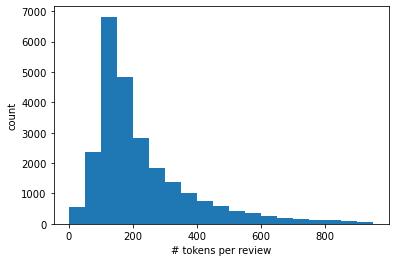

In [6]:
# 句子长度的直方图展示
plt.hist([len(line) for line in train_tokens], bins=range(0, 1000, 50))
plt.xlabel('# tokens per review')
plt.ylabel('count')
plt.show()

In [7]:
def truncate_pad(line, num_steps, padding_token):
    """截断或填充文本序列"""
    if len(line) > num_steps:
        return line[:num_steps]  # 句子截断
    return line + [padding_token] * (num_steps - len(line))  # 句子填充


num_steps = 500  # 句子长度为500
train_features = torch.tensor([truncate_pad(vocab[line], num_steps, vocab['<pad>']) for line in train_tokens])
print(train_features.shape)

torch.Size([25000, 500])


In [9]:
def load_array(data_arrays, batch_size, is_train=True):
    """Construct a PyTorch data iterator"""
    dataset = Data.TensorDataset(*data_arrays)
    return Data.DataLoader(dataset, batch_size,
                           shuffle=is_train)  # 训练模式下设置shuffle=True


def load_data_imdb(batch_size, num_steps=500):
    """返回数据迭代器和IMDb评论数据集的词表"""
    data_dir = '../../../../../../Other/datasets/aclImdb'
    train_data = read_imdb(data_dir, True)
    test_data = read_imdb(data_dir, False)
    train_tokens = tokenize(train_data[0], token='word')
    test_tokens = tokenize(test_data[0], token='word')
    vocab = Vocab(train_tokens, min_freq=5)
    train_features = torch.tensor([truncate_pad(vocab[line], num_steps,
                                                vocab['<pad>']) for line in train_tokens])
    test_features = torch.tensor([truncate_pad(vocab[line], num_steps,
                                               vocab['<pad>']) for line in test_tokens])
    train_iter = load_array((train_features, torch.tensor(train_data[1])),
                            batch_size)
    test_iter = load_array((test_features, torch.tensor(test_data[1])),
                           batch_size, is_train=False)
    return train_iter, test_iter, vocab


train_iter, test_iter, vocab = load_data_imdb(64)
for i, j in train_iter:
    print(i)
    print(i.shape)
    print(j)
    break

tensor([[    8,   387,     5,  ...,     0,     0,     0],
        [   48,     6,   166,  ...,     0,     0,     0],
        [ 2121,    40,   148,  ...,     0,     0,     0],
        ...,
        [   10,    20,    57,  ...,     0,     0,     0],
        [28845,     4,     2,  ...,     0,     0,     0],
        [  254,    96,     1,  ...,     0,     0,     0]])
torch.Size([64, 500])
tensor([0, 1, 0, 1, 0, 1, 0, 0, 0, 1, 0, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0,
        1, 0, 0, 1, 1, 0, 1, 1, 1, 1, 0, 1, 0, 0, 1, 1, 1, 1, 0, 0, 0, 0, 0, 1,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0])


### 模型训练

In [11]:
# 加载预训练词向量文件
glove_path = "../../../../../../Other/datasets/glove.6B.100d.txt"
glove_embedding = KeyedVectors.load_word2vec_format(glove_path, no_header=True)

glove_tokens = list(glove_embedding.key_to_index.keys())
vocab_token = vocab.idx_to_token

# 不在预训练词向量中出现的词
diff = np.setdiff1d(vocab_token, glove_tokens).tolist()
diff

['!!!!!!!',
 '!!!!!!!!!',
 '!!!<br',
 '!!<br',
 '!)',
 '!).',
 '!<br',
 '",',
 '".',
 '"...',
 '"1"',
 '"10',
 '"10"',
 '"10."',
 '"12',
 '"2"',
 '"20',
 '"24"',
 '"28',
 '"3',
 '"3"',
 '"42nd',
 '"8',
 '"<br',
 '"A',
 '"A"',
 '"ALIEN"',
 '"About',
 '"Absolute',
 '"After',
 '"Ah,',
 '"Air',
 '"Airplane!"',
 '"Airplane"',
 '"Al',
 '"Alice',
 '"Alien',
 '"Alive"',
 '"All',
 '"Amazing',
 '"American',
 '"An',
 '"Anchors',
 '"And',
 '"Angels',
 '"Animal',
 '"Anna',
 '"Anna"',
 '"Any',
 '"Apocalypse',
 '"Aqua',
 '"Are',
 '"Army',
 '"Arthur"',
 '"As',
 '"At',
 '"Atlantis"',
 '"Atomic',
 '"Attack',
 '"B',
 '"B"',
 '"Baby',
 '"Back',
 '"Bad',
 '"Basic',
 '"Batman',
 '"Batman"',
 '"Battlestar',
 '"Be',
 '"Beat',
 '"Beau',
 '"Beautiful',
 '"Beauty',
 '"Because',
 '"Before',
 '"Behind',
 '"Ben',
 '"Bend',
 '"Beowulf',
 '"Best',
 '"Better',
 '"Beverly',
 '"Beyond',
 '"Big',
 '"Big"',
 '"Bill',
 '"Black',
 '"Blade',
 '"Blair',
 '"Blazing',
 '"Blind',
 '"Blithe',
 '"Blood',
 '"Blow',
 '"Blue',
 '"Blu

In [12]:
embedding_weight = []
not_present_vec = [0] * 100  # 0向量(100为词向量长度)
for token in vocab_token:
    if token in diff:
        # 不在预训练词向量的词使用0向量表示
        embedding_weight.append(not_present_vec)
    else:
        embedding_weight.append(glove_embedding[token].tolist())
embeds = torch.tensor(embedding_weight)  # 模型预训练词向量矩阵

In [13]:
def accuracy(preds, y):
    """计算正确率"""
    rounded_preds = torch.argmax(preds, dim=1)
    correct = (rounded_preds == y).to(torch.float32)
    acc = correct.sum() / len(correct)
    return acc


def train(net, train_iter, loss, trainer, num_epochs, device):
    net.train()
    loss_list = []
    acc_list = []
    for epoch in range(num_epochs):
        for i, (features, labels) in enumerate(train_iter):
            features = features.to(device)
            labels = labels.to(device)
            trainer.zero_grad()
            pred = net(features)
            l = loss(pred, labels)
            acc = accuracy(pred, labels)
            l.backward()
            trainer.step()

            if i % 50 == 0:
                loss_list.append(l.item())
                acc_list.append(acc.item())
    return loss_list, acc_list


# 3个卷积层,卷积核宽度分别为3、4和5,均有100个输出通道
embed_size, kernel_sizes, nums_channels = 100, [3, 4, 5], [100, 100, 100]
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
lr, num_epochs = 0.001, 10

net = TextCNN(len(vocab), embed_size, kernel_sizes, nums_channels)
net.embedding.weight.data.copy_(embeds)
net.constant_embedding.weight.data.copy_(embeds)  # 使用模型预训练词向量矩阵
net.constant_embedding.weight.requires_grad = False  # 冻结网络层,使之不参与训练
net = net.to(device)
trainer = torch.optim.Adam(net.parameters(), lr=lr)
loss = nn.CrossEntropyLoss(reduction="sum")

loss_list, acc_list = train(net, train_iter, loss, trainer, num_epochs, device)

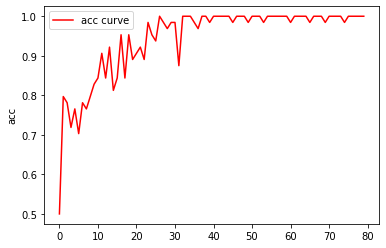

In [14]:
plt.plot(acc_list, label='acc curve', color='red')
plt.legend()
plt.ylabel('acc')
plt.show()

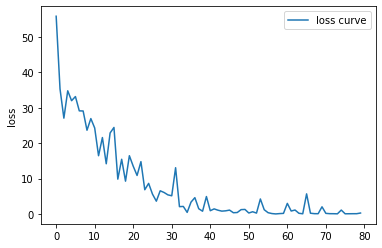

In [15]:
plt.plot(loss_list, label='loss curve')
plt.ylabel('loss')
plt.legend()
plt.show()